In [ ]:
!git clone https://github.com/PTRRupprecht/Understanding-style-transfer

Cloning into 'Understanding-style-transfer'...
remote: Enumerating objects: 138, done.
remote: Total 138 (delta 0), reused 0 (delta 0), pack-reused 138
Receiving objects: 100% (138/138), 7.31 MiB | 24.88 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [ ]:
!cp -R Understanding-style-transfer/clouds .

In [ ]:
!cp -R Understanding-style-transfer/cracked_concrete .

Vì file này dùng phiên bản tensorflow cũ nên mình cần chạy **dòng này trước** khi import các thư viện:

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import glob

from skimage import io
from sklearn.cluster import KMeans
import sklearn.metrics as sm

import tensorflow as tf

In [ ]:
# Load model (a variant of the Inception architecture)
# Tải mô hình GoogleNet dựa trên cấu trúc Inception Block.
!wget -nc https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip

model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()

sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

--2021-06-14 08:17:11--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘inception5h.zip’

inception5h.zip     100%[===================>]  47.62M  87.2MB/s    in 0.5s    

2021-06-14 08:17:12 (87.2 MB/s) - ‘inception5h.zip’ saved [49937555/49937555]

Archive:  inception5h.zip
  inflating: imagenet_comp_graph_label_strings.txt  
  inflating: tensorflow_inception_graph.pb  
  inflating: LICENSE                 
Instructions for updating:
Use tf.gfile.GFile.


In [ ]:
# Lấy toàn bộ các lớp CNN, ở đây số lớp CNN cực lớn!!!
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

Number of layers 59
Total number of feature channels: 7548


Đoạn code dưới đây sẽ đi tính ma trận Gram của các đặc trưng lấy được từ lớp CNN thứ 30. Mình có tất cả 40 ảnh nên mỗi ảnh sẽ có 1 ma trận Gram.
Ma trận Gram biểu thị tương quan giữa các đặc trưng trên ảnh. Về hệ số tương quan thì mấy đứa đọc ở [đây](https://www.careerlink.vn/en/careertools/economic-knowledge/he-so-tuong-quan-correlation-coefficient-la-gi-va-ung-dung).

In [ ]:
layerX = layers[29]
layerX = layerX+':0'
'''
Ở đây với mỗi bức ảnh lấy được từ thư mục clouds, nó sẽ tiến hành đọc bức ảnh đã cho
bằng lệnh img = mpimg.imread(image).
Sau đó ta sẽ tính output lấy ra tại layerX, ở đây mình có thể lấy layer khác, ko nhất thiết là layer thứ
30. 
Phần đặc trưng tính ra được sẽ lưu vào cái biến activations.
'''
FileList_anima = glob.glob('clouds/*.jpg')
image = FileList_anima[0]
img = mpimg.imread(image)
activations = sess.run(layerX,{t_input: img})

# Z is the 3d matrix containing the 40 2d Gram matrices for the 40 input images
# Biến Z sẽ lưu ma trận gram của 40 bức ảnh, rõ ràng nó phải có 3 chiều vì ma trận gram có 2 chiều rồi :)) 
Z = np.zeros((activations.shape[3],activations.shape[3],40))

# compute Z for cloud pictures
'''

'''
FileList_anima = glob.glob('clouds/*.jpg')
for idx in range(20):
    print(idx)
    image = FileList_anima[idx]
    img = mpimg.imread(image)

    activations = sess.run(layerX,{t_input: img})
    # Để tính ma trận gram cho từng bức ảnh, ta sẽ thực hiện vòng for và tính tương quan thôi, cái flatten ở đây
    # là dùng là vì cái đặc trưng lấy ra của mình là 2 chiều, mình sẽ đưa nó về 1 chiều rồi mới tính hệ số tương quan
    # Trong file khác người ta ko tính thế này vì làm như này chậm, mà code cũng rối.
    for jj in range(activations.shape[3]):
        A = np.squeeze(activations[0,:,:,jj])
        for kk in range(activations.shape[3]):
            B = np.squeeze(activations[0,:,:,kk])
            Z[jj,kk,idx] = np.corrcoef(A.flatten(),B.flatten())[0,1]

# compute Z for cracked concrete pictures
FileList_anima = glob.glob('cracked_concrete/*.jpg')    
for idx in range(20):
    print(idx+20)
    image = FileList_anima[idx]
    img = mpimg.imread(image)

    activations = sess.run(layerX,{t_input: img})

    for jj in range(activations.shape[3]):
        A = np.squeeze(activations[0,:,:,jj])
        for kk in range(activations.shape[3]):
            B = np.squeeze(activations[0,:,:,kk])
            Z[jj,kk,idx+20] = np.corrcoef(A.flatten(),B.flatten())[0,1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [ ]:
# ở đây mình sẽ thấy activations có tất cả 256 đặc trưng, mỗi đặc trưng có kích thước 13 x 17
# Đừng bất ngờ vì mình đã dùng đến lớp CNN thứ 30, bức ảnh đầu vào bây giờ nó chỉ còn size thế thôi.
print(activations.shape)

(1, 13, 17, 256)

In [ ]:
print(Z[:, :, 0])

[[ 1.         -0.33139215 -0.0845287  ...  0.33846883  0.25266719
  -0.51709823]
 [-0.33139215  1.          0.66262812 ... -0.15459656  0.1269275
   0.26865928]
 [-0.0845287   0.66262812  1.         ... -0.24213422  0.27952881
   0.07681327]
 ...
 [ 0.33846883 -0.15459656 -0.24213422 ...  1.         -0.37622737
   0.02016914]
 [ 0.25266719  0.1269275   0.27952881 ... -0.37622737  1.
  -0.476733  ]
 [-0.51709823  0.26865928  0.07681327 ...  0.02016914 -0.476733
   1.        ]]


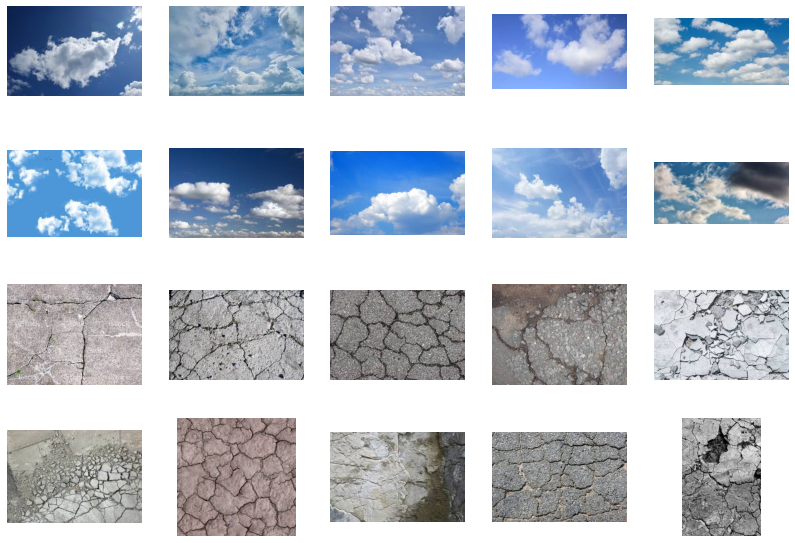

In [ ]:
# Show example input images

plt.figure(5)
for kk in range(20):
    ax = plt.subplot(4, 5, kk+1)
    if kk < 10:
        FileList_anima = glob.glob('clouds/*.jpg')
        image = FileList_anima[kk*2]
        img = mpimg.imread(image)
    else:
        FileList_anima = glob.glob('cracked_concrete/*.jpg')
        image = FileList_anima[(kk-10)*2]
        img = mpimg.imread(image)
    plt.imshow(img,cmap=plt.get_cmap('Greys'))
    plt.axis('off') 

Đến đây mình sẽ có 40 ma trận gram với kích thước 256 x 256. Đơn giản vì với mỗi
đặc trưng thì mình sẽ tính hệ số tương quan của nó với tất cả các đặc trưng khác, bao gồm chính nó. Do đó ma trận Gram này sẽ luôn có thành phần đường chéo bằng 1. <br/>
Ở đây ta sẽ thấy mỗi hàng của ma trận sẽ là 1 vector thể hiện hệ số tương quan của đặc trưng biểu diễn bởi hàng đó với tất cả các đặc trưng khác. Do đó các đặc trưng gần giống nhau thì các vector này càng nằm gần nhau.
Do đó để gom các đặc trưng gần giống nhau lại thì ta sẽ tiến hành dùng thuật toán K-mean. <br/>

Lúc này K-mean sẽ phân cụm các đặc trưng đã cho làm 7 nhóm, các đặc trưng trong cùng 1 nhóm thì sẽ có phần tương đồng nhau vì hệ số tương quan giữa nó với các đặc trưng khác là xêm xêm. <br />


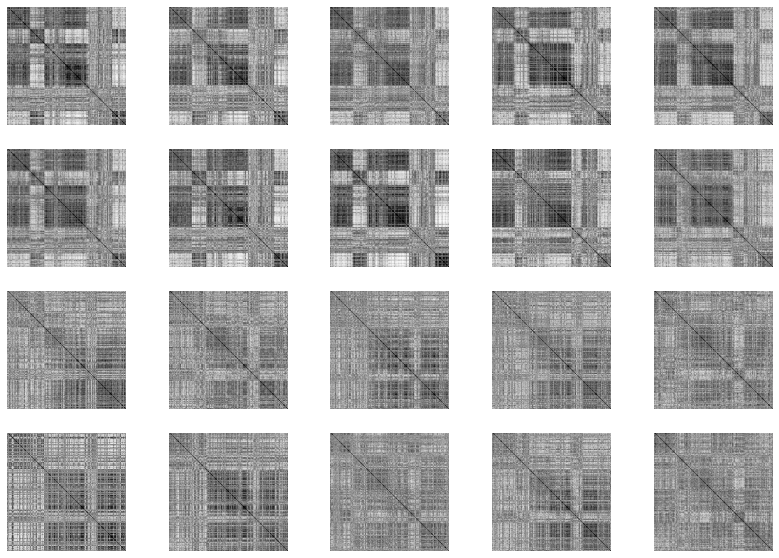

In [ ]:
# compute mean Gram matrix (across all 40 input images)
# Tính ma trận Gram trung bình.
Z_mean = np.mean(Z,axis=2)

# compute k-means clustering
# since k-means clustering is variable across repetitions, results can look slightly different when repeated
# Thực hiện thuật toán K-mean chia các đặc trưng đã cho làm 7 nhóm,
# các đặc trưng gần giống nhau sẽ cùng thuộc 1 nhóm.
model = KMeans(n_clusters=7)
model.fit(Z_mean)
indizes = model.labels_
# Sau khi phân cụm thì mình sắp xếp lại các đặc trưng
# ở đây mình sẽ dùng argsort sau khi đã gán nhán cho các đặc trưng
order_indizes = np.argsort(indizes)

# plot Gram matrices with clustered feature axes
plt.figure(4)
for kk in range(20):
    ax = plt.subplot(4, 5, kk+1)
    Z2 = np.zeros(Z_mean.shape)
    ZXY = np.copy(Z_mean)
    '''
    Ở đây chỉ khởi tạo ZXY là ma trận có kích thước 256 x 256
    Vì mình đã tiến hành phân cụm nên ZXy [jj. ii] là tương quan giữa đặc
    trưng thứ jj và ii sẽ trở thành tương quan giữa đặc trưng thứ order_indizes[jj]
    và order_indizes[ii].
    '''
    for jj in range(Z_mean.shape[0]):
        for ii in range(Z_mean.shape[1]):
            ZXY[jj,ii] = Z[order_indizes[jj],order_indizes[ii],kk*2]
    plt.imshow(ZXY,cmap=plt.get_cmap('Greys'), vmin=-0.8, vmax=0.8)
    plt.axis('off')    

Đến đây ta thấy các ma trận gram của ảnh mây sẽ gần giống nhau, tương tự cho các ma trận gram của ảnh nền đất bị nứt.
Như vậy đến đây ta sẽ có cách tách lấy style của 1 bức ảnh dựa trên cái ma trận gram này mà ko quan tâm đến nội dung bức ảnh ra sao. (Để ý thấy mặc dù nội dung ảnh mây khác nhau nhưng các ma trận gram vẫn xêm xêm nhau). 